# Using Grad-CAM for Visualizing CNNs

Continuing from the CAM tutorial

As usual, we will work with the dogscats dataset.

Also I would highly recommend having seen the Forward Hooks notebook https://github.com/TheShadow29/FAI-notes/blob/master/notebooks/Using-Forward-Hook-To-Save-Features.ipynb

In [1]:
import matplotlib
matplotlib.use('Agg')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import skimage.transform as skt

In [4]:
PATH = "../data/dogscats/"
sz=224

In [5]:
arch=resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

### Grad-CAM

Now we want to do Grad-CAM. The main advantage is that there is no need to change your model at all.

In [6]:
learn_gc = ConvLearner.pretrained(arch, data)

In [ ]:
learn_gc.fit(1e-2, 1, cycle_len=1, best_save_name='gc1')

In [7]:
learn_gc.load('gc1')

As you might have figured out from the name itself, Gradient-CAM uses gradients for updates. So we need to save the gradients using `register_backward_hook` function. Have a look at the official documentation here: https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks

Incidentally, the SaveFeatures model can be used as is with the difference of choosing which hook (forward or backward) in the case of SaveGradients.

In [8]:
class SaveFeaturesGradients:
    def __init__(self, m):
        self.handle_forw = m.register_forward_hook(self.forw_hook_fn)
        self.handle_back = m.register_backward_hook(self.back_hook_fn)

    def forw_hook_fn(self, m, inp, outp):
        self.feats = outp

    def back_hook_fn(self, m, grad_inp, grad_outp):
        pdb.set_trace()
        self.grads_inp = grad_inp
        self.grads_outp = grad_outp
        
    def remove_forw(self):
        self.handle_forw.remove()
        
    def remove_back(self):
        self.handle_back.remove()

Refer to https://ramprs.github.io/2017/01/21/Grad-CAM-Making-Off-the-Shelf-Deep-Models-Transparent-through-Visual-Explanations.html#grad-cam--gradient-weighted-class-activation-mapping for the equations.

In particular note: $\alpha_k^c$ do the same task as the weights of the softmax layer in the previous CAM code

In [9]:
learn_gc.unfreeze()
m_gc = learn_gc.model

In [10]:
x, y = next(iter(data.fix_dl))

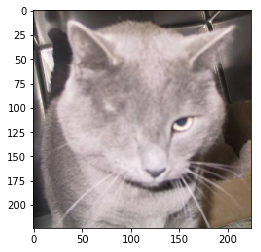

In [11]:
idx = 1

x1 = data.val_ds.denorm(x)
plt.imshow(x1[idx])

In [12]:
m_gc[7]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(

In [13]:
sfg = SaveFeaturesGradients(m_gc[7])

In [14]:
log_probs = m_gc(V(x))
# err = learn_gc.crit(log_probs, V(y))
# err.backward(retain_graph=True)

In [15]:
one_hot = torch.FloatTensor(64, log_probs.size()[-1]).zero_()
one_hot[idx, 0] = 1.0
one_hot = to_gpu(one_hot)

In [16]:
one_hot


    0     0
    1     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
[torch.cuda.FloatTensor of size 64x2 (GPU 0)]

In [17]:
yc = log_probs * V(one_hot)

In [21]:
ycs = torch.sum(yc)

In [22]:
m_gc.zero_grad()
# lgprb.backward(gradient=one_hot, retain_graph=True)
# log_probs.backward(gradient=one_hot, retain_graph=True)
ycs.backward(retain_graph=True)

> <ipython-input-8-e6e7f71bd382>(11)back_hook_fn()
-> self.grads_inp = grad_inp
(Pdb) grad_inp
(Variable containing:
( 0 , 0 ,.,.) = 
1.00000e-03 *
  0.0000  0.0000 -0.0001  ...  -0.0001  0.0000 -0.0001
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000 -0.0001
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...  -0.0001 -0.0001 -0.0001
  0.0000 -0.0001 -0.0001  ...  -0.0001 -0.0001 -0.0001
  0.0000 -0.0001 -0.0001  ...  -0.0001 -0.0001  0.0000

( 0 , 1 ,.,.) = 
1.00000e-03 *
  0.0000  0.0000  0.0006  ...   0.0006  0.0006  0.0006
  0.0000  0.0000  0.0006  ...   0.0006  0.0006  0.0006
  0.0000  0.0000  0.0006  ...   0.0006  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0006  0.0006  ...   0.0006  0.0006  0.0006
  0.0000  0.0006  0.0006  ...   0.0006  0.0006  0.0006
  0.0000  0.0000  0.0006  ...   0.0006  0.0006  0.0000

( 0 , 2 ,.,.) = 
1.00000e-03 *
  0.0000  0.0000 -

(Pdb) grad_inp.data.shape
*** AttributeError: 'tuple' object has no attribute 'data'
(Pdb) grad_inp.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
(Pdb) grad_inp[0].shape
torch.Size([64, 512, 7, 7])
(Pdb) q


BdbQuit: 

In [ ]:
class GradCAM:
    def __init__(self, model):
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()
        self.model = model

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0]

        for ind, module in enumerate(self.model.named_modules()):
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

In [ ]:
gcam = GradCAM(learn_gc.models.model)

In [ ]:
lprb = gcam.model(V(x1v))

In [ ]:
gcam.model.zero_grad()
lprb.backward(gradient=one_hot, retain_graph=True)

In [ ]:
lprb

In [ ]:
gcam.all_grads[id(list(gcam.model.named_modules())[6][1])]